# GitHub Link
https://github.com/MinAungOo64/DSA4262/tree/main/Assignment%202

# Read Files

pip install -U numpy pandas matplotlib seaborn scikit-learn shap scipy

In [50]:
# =========================
# Standard library
# =========================
import os

# =========================
# Core scientific stack
# =========================
import numpy as np
import pandas as pd

# =========================
# Visualisation
# =========================
import matplotlib.pyplot as plt
import seaborn as sns

# =========================
# Scikit-learn: model selection
# =========================
from sklearn.model_selection import GridSearchCV, StratifiedKFold, train_test_split

# =========================
# Scikit-learn: preprocessing / features
# =========================
from sklearn.compose import ColumnTransformer
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS, TfidfVectorizer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline

# =========================
# Scikit-learn: models
# =========================
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

# =========================
# Scikit-learn: metrics
# =========================
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    f1_score,
    precision_score,
    recall_score
)

# =========================
# Explainability / utilities
# =========================
import shap
from scipy.special import expit

In [51]:
# change dir
os.chdir('C:\\Users\\e0979790\\OneDrive - National University of Singapore\\Module Materials\\Year 4 Sem 2\\DSA4262\\Individual Assigment\\Assignment 2\\dreaddit')
# read files in dir
files = os.listdir()
print(files)
# read this file:
train = pd.read_csv('dreaddit-train.csv')
test = pd.read_csv('dreaddit-test.csv')
# show col names
print(list(train.columns))

['dreaddit-test.csv', 'dreaddit-train.csv']
['subreddit', 'post_id', 'sentence_range', 'text', 'id', 'label', 'confidence', 'social_timestamp', 'social_karma', 'syntax_ari', 'lex_liwc_WC', 'lex_liwc_Analytic', 'lex_liwc_Clout', 'lex_liwc_Authentic', 'lex_liwc_Tone', 'lex_liwc_WPS', 'lex_liwc_Sixltr', 'lex_liwc_Dic', 'lex_liwc_function', 'lex_liwc_pronoun', 'lex_liwc_ppron', 'lex_liwc_i', 'lex_liwc_we', 'lex_liwc_you', 'lex_liwc_shehe', 'lex_liwc_they', 'lex_liwc_ipron', 'lex_liwc_article', 'lex_liwc_prep', 'lex_liwc_auxverb', 'lex_liwc_adverb', 'lex_liwc_conj', 'lex_liwc_negate', 'lex_liwc_verb', 'lex_liwc_adj', 'lex_liwc_compare', 'lex_liwc_interrog', 'lex_liwc_number', 'lex_liwc_quant', 'lex_liwc_affect', 'lex_liwc_posemo', 'lex_liwc_negemo', 'lex_liwc_anx', 'lex_liwc_anger', 'lex_liwc_sad', 'lex_liwc_social', 'lex_liwc_family', 'lex_liwc_friend', 'lex_liwc_female', 'lex_liwc_male', 'lex_liwc_cogproc', 'lex_liwc_insight', 'lex_liwc_cause', 'lex_liwc_discrep', 'lex_liwc_tentat', 'lex_

# EDA

We observe that the dataset is quite balanced hence resampling is not necessary.

In [52]:
train.shape
label_distribution = train['label'].value_counts(normalize=True)
print(label_distribution)
# create text_len column
train['text_len'] = train['text'].apply(len)
test['text_len'] = test['text'].apply(len)

label
1    0.524313
0    0.475687
Name: proportion, dtype: float64


Let us visualise the distribution of stress and non-stress posts across subreddits.

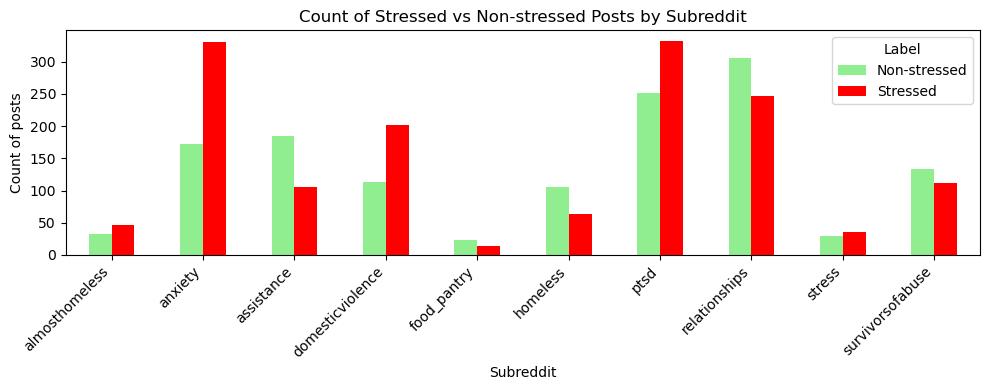

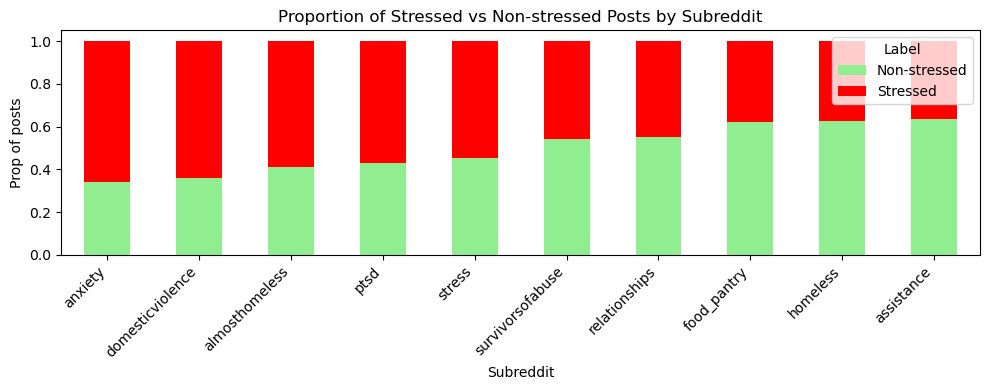

In [53]:
# plt as bar chart and categorise by subreddit
counts = (
    train
    .groupby(['subreddit', 'label'])
    .size()
    .reset_index(name='count')
)
# print(counts.head())

counts['prop'] = (
    counts['count'] /
    counts.groupby('subreddit')['count'].transform('sum')
)
# print(counts.head())

pivot = counts.pivot(index='subreddit', columns='label', values='count')
# change color based on label, stressed = 1 red, non-stressed = 0 green
pivot.plot(
    kind='bar',
    stacked=False,
    figsize=(10, 4),
    color={0: 'lightgreen', 1: 'red'}
)

plt.ylabel("Count of posts")
plt.xlabel("Subreddit")
plt.title("Count of Stressed vs Non-stressed Posts by Subreddit")
plt.legend(["Non-stressed", "Stressed"], title="Label")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# plot proportion of stressed vs non-stressed posts by subreddit
# sort by proportion of stressed posts
counts['prop'] = counts['count'] / counts.groupby('subreddit')['count'].transform('sum')
pivot_prop = counts.pivot(index='subreddit', columns='label', values='prop')
pivot_prop = pivot_prop.sort_values(by=1, ascending=False)
pivot_prop.plot(
    kind='bar',
    stacked=True,
    figsize=(10, 4),
    color={0: 'lightgreen', 1: 'red'}
)
plt.ylabel("Prop of posts")
plt.xlabel("Subreddit")
plt.title("Proportion of Stressed vs Non-stressed Posts by Subreddit")
plt.legend(["Non-stressed", "Stressed"], title="Label")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


While the volume of stress-related content varies across the dataset, the relative proportion of these posts provides deeper insight into the emotional landscape of specific communities. High-density clusters are evident in subreddits like r/anxiety and r/domesticviolence, which serve as primary outlets for acute emotional distress.

A particularly striking contrast emerges between r/almosthomeless and r/homeless. Despite their thematic similarities, r/almosthomeless exhibits a significantly higher proportion of stress posts. This disparity may be attributed to the nature of the stressors involved:  
*  Anticipatory Anxiety vs. Survival Adaptation: Users in r/almosthomeless are often navigating the "liminal space" of an impending crisis. The high stress levels reflect the frantic effort to avert a life-altering event.  
* The "Cliff-Edge" Effect: Once an individual is already in r/homeless, the nature of the posts may shift from high-arousal stress (anxiety and panic) toward resource acquisition, logistical navigation, or a state of chronic habituation to their circumstances. 

This suggests that the uncertainty of a looming threat may generate more visible linguistic markers of stress than the threat itself once it has been realized. We will explore this further in the section after correlation analysis.


Before we compute correlations, we compute a new modified label for stress, by turning it from (0,1) to (-1,1) * confidence.

In [54]:
# Create new label column by changing label from 0,1 to -1,1 and multiplying by confidence
train['modified_label'] = train['label'].apply(lambda x: -1 if x == 0 else 1) * train['confidence']
# select only the relevant columns for correlation analysis, from col 8 onwards
correlation_data = train.iloc[:, 8:]  # include modfied_label
# compute correlation matrix
correlation_matrix = correlation_data.corr()
# print correlation of modified_label with other features, sorted by magnitude but keep the sign
modified_label_correlation = correlation_matrix['modified_label'].drop('modified_label').sort_values(key=abs, ascending=False)
# show top k correlations
k = 10
modified_label_correlation = modified_label_correlation.head(k)
print("Correlation of modified_label with other features:")
print(modified_label_correlation)
print()
# build another correlation data but replace modified_label with original label
correlation_data_original_label = train.iloc[:, 8:-1]  # exclude modified_label
correlation_data_original_label['label'] = train['label']
correlation_matrix_original_label = correlation_data_original_label.corr()
# print correlation of label with other features, sorted by magnitude but keep the sign
label_correlation = correlation_matrix_original_label['label'].drop('label').sort_values(key=abs, ascending=False)
# show top k correlations
label_correlation = label_correlation.head(k)
print("Correlation of original label with other features:")
print(label_correlation)
print()
# print correlation of numerical features with themselves, sorted by magnitude but keep the sign and drop duplicate pairs and self-correlation
numerical_correlation = correlation_matrix.drop('modified_label').drop('modified_label', axis=1)
numerical_correlation = numerical_correlation.where(np.triu(np.ones(numerical_correlation.shape), k=1).astype(bool))
numerical_correlation = numerical_correlation.stack().sort_values(key=abs, ascending=False)
print("Correlation of numerical features with each other:")
print(numerical_correlation.head(k))

Correlation of modified_label with other features:
lex_liwc_Tone              -0.475762
lex_liwc_Clout             -0.437422
lex_liwc_i                  0.432602
lex_liwc_negemo             0.425701
sentiment                  -0.331774
lex_dal_min_pleasantness   -0.325888
lex_liwc_posemo            -0.297652
lex_liwc_Authentic          0.291925
lex_liwc_anx                0.286850
lex_liwc_social            -0.270415
Name: modified_label, dtype: float64

Correlation of original label with other features:
lex_liwc_Tone              -0.436005
lex_liwc_Clout             -0.403804
lex_liwc_i                  0.400440
lex_liwc_negemo             0.387979
sentiment                  -0.305157
lex_dal_min_pleasantness   -0.297439
lex_liwc_Authentic          0.275282
lex_liwc_posemo            -0.270672
lex_liwc_anx                0.260146
lex_liwc_social            -0.250052
Name: label, dtype: float64

Correlation of numerical features with each other:
lex_liwc_WC       text_len              

 Looking at the top k correlations with the new label, there are no clear strong correlations with any of the features, indicating possible non-linear relationships or the need for more complex models to capture the underlying patterns in the data. 

The highest negative correlation are Tone and Clout, which suggests that post with positive tone and high clout (degree of confidence, social dominance and authority expressed in language) are less likely to be stress-related. The highest positive correlation is "i" and "negemo" which suggests that posts with more self-references and negative emotions are more likely to be stress-related.

Let us analyse more on r/almosthomeless and r/homeless.

                lex_liwc_anx  lex_liwc_negemo
subreddit                                    
almosthomeless      0.362125         2.031375
homeless            0.404524         2.119167



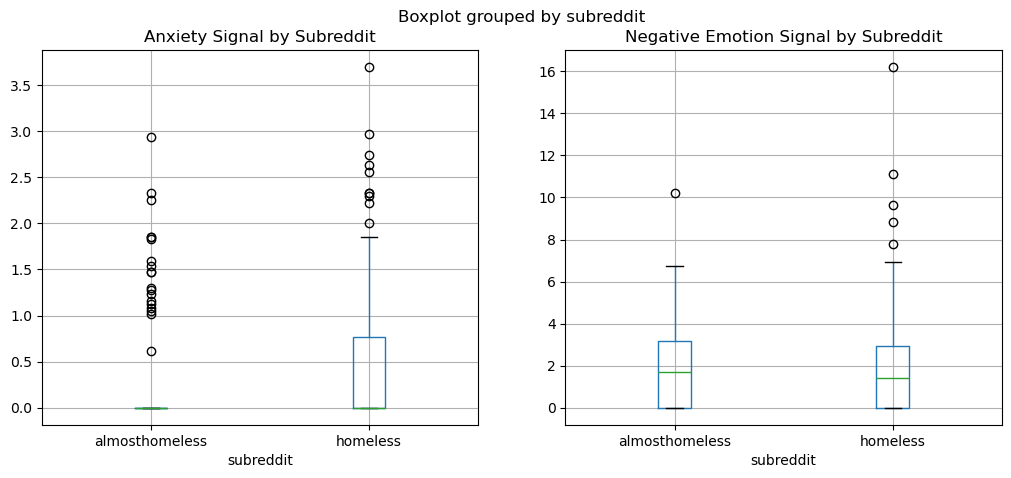

In [55]:
stress_comparison = train[train['subreddit'].isin(['almosthomeless', 'homeless'])].copy()
stress_signals_comparison = stress_comparison.groupby('subreddit')[['lex_liwc_anx', 'lex_liwc_negemo']].mean()
print(stress_signals_comparison)
# leave a line break
print()

# boxplot of lex_liwc_anx and lex_liwc_negemo by subreddit
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
stress_comparison.boxplot(column='lex_liwc_anx', by='subreddit', ax=axes[0])
axes[0].set_title('Anxiety Signal by Subreddit')
stress_comparison.boxplot(column='lex_liwc_negemo', by='subreddit', ax=axes[1])
axes[1].set_title('Negative Emotion Signal by Subreddit')
plt.show()

# # number of outliers in anxiety boxplot
# anx_outliers = stress_comparison.groupby('subreddit')['lex_liwc_anx'].apply(lambda x: ((x < (x.quantile(0.25) - 1.5 * (x.quantile(0.75) - x.quantile(0.25)))) | (x > (x.quantile(0.75) + 1.5 * (x.quantile(0.75) - x.quantile(0.25))))).sum())
# print("Number of outliers in anxiety signal by subreddit:")
# print(anx_outliers)
# print()

 Interestingly, anxiety levels and spread in r/homeless are higher than in r/almosthomeless. This contradicts our hypothesis that anticipatory anxiety would result in a greater proportion of stress in r/almosthomeless compared to r/homeless is not supported by the data.

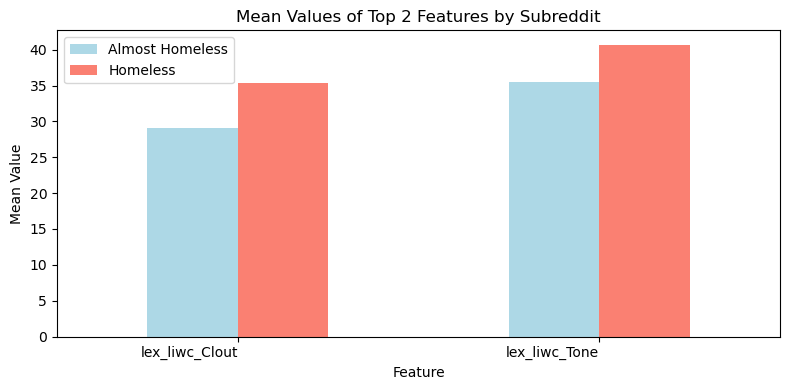

In [56]:
# for col from col 8 onwards, compute the mean value of col for the two subreddits and print the top 5 features with the largest difference in mean values between the two subreddits
# Subset only the two subreddits
subset = train[train['subreddit'].isin(['almosthomeless', 'homeless'])].copy()

# Only numeric features
feature_cols = subset.columns[8:]  # Assuming numeric features start from column index 8

# Compute means
means = (
    subset
    .groupby('subreddit')[feature_cols]
    .mean()
    .T
)

# Rename columns for clarity
means.columns = ['almosthomeless_mean', 'homeless_mean']

# Compute difference (keep signed + absolute)
means['signed_diff'] = means['almosthomeless_mean'] - means['homeless_mean']
means['abs_diff'] = means['signed_diff'].abs()

# Sort by largest absolute difference
mean_diff_sorted = means.sort_values(by='abs_diff', ascending=False)

# Show top 5 with original values
mean_diff_sorted.head(5)

# plot to show the mean values of the top 2 features for the two subreddits in one bar chart, with different colors for the two subreddits
top_features = mean_diff_sorted.head(2).index
top_means = means.loc[top_features, ['almosthomeless_mean', 'homeless_mean']]
top_means.plot(kind='bar', figsize=(8, 4), color=['lightblue', 'salmon'])
plt.title('Mean Values of Top 2 Features by Subreddit')
plt.ylabel('Mean Value')
plt.xlabel('Feature')
plt.xticks(rotation=0, ha='right')
plt.legend(['Almost Homeless', 'Homeless'])
plt.tight_layout()
plt.show()

However, as mentioned earlier, Tone and Clout are the highest negatively correlated features with stress, meaning that the higher the tone and clout, the less likely the post is stress-related. This could explain why r/almosthomeless which has a lower tone and clout has a higher proportion of stress-related posts compared to r/homeless which has a higher tone and clout. This suggests that the nature of the posts in r/almosthomeless may be more emotionally charged and less authoritative, which could contribute to the higher levels of stress observed in that subreddit.

Lastly, we run TF-IDF on the text for stress and non-stress posts.  

,stress_word,stress_tfidf_delta,non_stress_word,non_stress_tfidf_delta
0,feel,0.022891,url,-0.012908
1,don,0.019509,survey,-0.009731
2,just,0.018273,thank,-0.009217
3,like,0.014435,met,-0.007511
4,anxiety,0.014059,years,-0.007093
5,know,0.012851,link,-0.005453
6,ve,0.008814,share,-0.005419
7,feeling,0.008814,food,-0.004850
8,scared,0.008276,interested,-0.004583
9,bad,0.007408,support,-0.004550


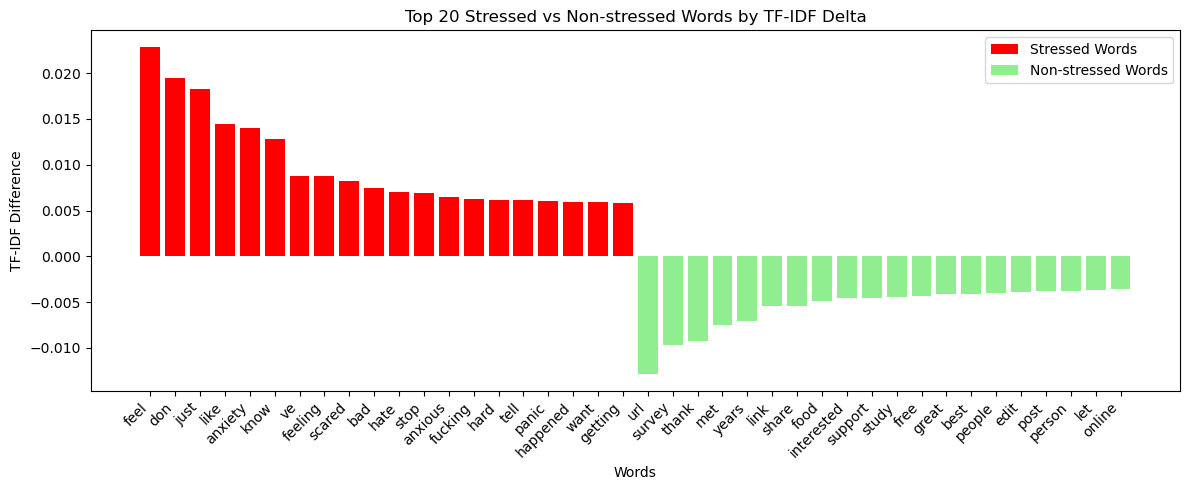

In [57]:
tfidf = TfidfVectorizer(
    stop_words='english',
    max_features=5000,
    min_df=5
)

X = tfidf.fit_transform(train['text'])
feature_names = tfidf.get_feature_names_out()

stress_mean = X[train['label'] == 1].mean(axis=0)
nonstress_mean = X[train['label'] == 0].mean(axis=0)

diff = np.asarray(stress_mean - nonstress_mean).flatten()

top_stress_words = sorted(
    zip(feature_names, diff),
    key=lambda x: x[1],
    reverse=True
)[:20]

top_nonstress_words = sorted(
    zip(feature_names, diff),
    key=lambda x: x[1]
)[:20]

# Convert to DataFrame
stress_df = pd.DataFrame(top_stress_words, columns=["stress_word", "stress_tfidf_delta"])
nonstress_df = pd.DataFrame(top_nonstress_words, columns=["non_stress_word", "non_stress_tfidf_delta"])
combine_df = pd.concat([stress_df, nonstress_df], axis=1)
display(combine_df)

# plot the top 20 stress words and top 20 non-stress words in one bar chart, with different colors for stress and non-stress words
plt.figure(figsize=(12, 5))
plt.bar(stress_df['stress_word'], stress_df['stress_tfidf_delta'], color='red', label='Stressed Words')
plt.bar(nonstress_df['non_stress_word'], nonstress_df['non_stress_tfidf_delta'], color='lightgreen', label='Non-stressed Words')
plt.xlabel('Words')
plt.ylabel('TF-IDF Difference')
plt.title('Top 20 Stressed vs Non-stressed Words by TF-IDF Delta')
plt.xticks(rotation=45, ha='right')
plt.legend()
plt.tight_layout()
plt.show()

We calculate the TF-IDF delta for each word by subtracting the average TF-IDF score of that word in non-stress posts from its average TF-IDF score in stress posts. This allows us to identify words that are more characteristic of stress-related content compared to non-stress content.  

TF-IDF analysis reveals that stressed posts are characterised by emotional disclosure and internal distress markers such as “feel”, “anxiety”, “scared”, and “panic”. These words reflect heightened negative affect and align with earlier LIWC findings of increased negative emotion and reduced tone.

Additionally, stressed posts contain conversational and cognitive processing markers (e.g., “just”, “know”, “like”), suggesting rumination and self-focused reflection.  
In contrast, non-stressed posts are dominated by informational and transactional language (e.g., “url”, “survey”, “link”, “share”), along with polite and positive terms such as “thank” and “great”. This indicates a more task-oriented and socially functional communication style.

# Data Preprocessing for Modelling

In [58]:
# show distribution of test labels
test_label_distribution = test['label'].value_counts(normalize=True)
print("Test label distribution:")
print(test_label_distribution)

Test label distribution:
label
1    0.516084
0    0.483916
Name: proportion, dtype: float64


# Modelling

In this study, we evaluate three modelling approaches: (1) a text-only TF-IDF + Logistic Regression model, (2) an engineered-feature model using LIWC, sentiment, and related numerical features with Logistic Regression, and (3) a hybrid model combining TF-IDF text features with engineered linguistic features. Logistic Regression is used consistently across all three models to ensure methodological comparability and interpretability. As a linear classifier, it provides transparent feature coefficients, allowing us to directly examine which words and psychological markers contribute to stress predictions. The text-only model captures surface lexical signals, the engineered-feature model isolates psychologically grounded indicators such as emotional tone and anxiety markers, and the hybrid model evaluates whether combining lexical and structured linguistic features improves predictive performance. This structured comparison allows us to assess the relative contribution of raw textual content versus theoretically informed linguistic features, while maintaining interpretability necessary for meaningful analysis and deployment discussion.

Although Transformer-based models (e.g., BERT or DistilBERT) typically achieve strong predictive performance in text classification tasks, they were not adopted as the primary modelling approach in this study due to considerations of interpretability and analytical depth. Transformer models rely on complex, non-linear contextual embeddings, making it difficult to directly attribute predictions to specific words or linguistic features. Given that this assignment emphasises sense-making, error analysis, subreddit-level comparison, and feature interpretability, a linear modelling framework was better aligned with the objectives. Logistic Regression enables transparent examination of feature coefficients, allowing us to identify lexical and psychologically grounded stress markers and systematically analyse failure cases. While a Transformer model may potentially yield a higher F1-score, the marginal performance gain would come at the cost of reduced interpretability and limited explanatory clarity, which are central to the goals of this assignment.

## TF-IDF + Logistic Regression (Text-Only Baseline)

TF-IDF + Log Reg model takes computed TF-IDF features from text only and trains a logistic regression classifier to predict stress labels. This approach serves as a strong baseline for text classification tasks, leveraging the importance of words in the context of the dataset.  
We run stratified 5-fold cross-validation to evaluate the model's performance, ensuring that each fold maintains the same proportion of stress and non-stress posts as the original dataset. The average F1-score across the folds is reported as the final performance metric, providing a balanced measure of precision and recall for the classification task.  
We also run grid search to find the best hyperparameters for the logistic regression model, including vocabulary size max features, the regularization strength (C) and the minimum number times the word appears in a document min_df. This helps to optimize the model's performance by preventing overfitting and improving generalization to unseen data.

### Model fitting and evaluation

In [59]:
# Define pipeline and parameter grid for grid search

X = train["text"]
y = train["label"]

pipe = Pipeline([
    ("tfidf", TfidfVectorizer(stop_words="english")),
    ("clf", LogisticRegression(
        max_iter=2000,
        class_weight="balanced",
        solver="liblinear"
    ))
])

param_grid = {
    "tfidf__max_features": [5000, 10000],
    "tfidf__ngram_range": [(1,1), (1,2), (1,3), (2,2)],
    "tfidf__min_df": [2, 5, 10],
    "clf__C": [0.01, 0.1, 1.0, 10.0],
}

In [60]:
# run grid search with stratified 5-fold cross-validation, shuffle the data and set random state for reproducibility

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

grid = GridSearchCV(
    pipe,
    param_grid,
    scoring="f1",
    cv=cv,
    n_jobs=-1,
    return_train_score=True,
    verbose=1
)

grid.fit(X, y)

Fitting 5 folds for each of 96 candidates, totalling 480 fits


,estimator,Pipeline(step...liblinear'))])
,param_grid,"{'clf__C': [0.01, 0.1, ...], 'tfidf__max_features': [5000, 10000], 'tfidf__min_df': [2, 5, ...], 'tfidf__ngram_range': [(1, ...), (1, ...), ...]}"
,scoring,'f1'
,n_jobs,-1
,refit,True
,cv,StratifiedKFo... shuffle=True)
,verbose,1
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,True
,input,'content'


In [61]:
# store results in dataframe
results_df = pd.DataFrame(grid.cv_results_)

# Keep only relevant columns
cols_to_keep = [
    "mean_test_score",
    "mean_train_score",
    "param_tfidf__max_features",
    "param_tfidf__ngram_range",
    "param_tfidf__min_df",
    "param_clf__C"
]

results_df = results_df[cols_to_keep]

# Sort by best validation F1
results_df = results_df.sort_values(
    by="mean_test_score",
    ascending=False
).reset_index(drop=True)
# rename test to val
results_df = results_df.rename(columns={
    "mean_test_score": "mean_val_f1",
    "std_test_score": "std_val_f1",
    "mean_train_score": "mean_train_f1",
})

display(results_df.head(5))

,mean_val_f1,mean_train_f1,param_tfidf__max_features,param_tfidf__ngram_range,param_tfidf__min_df,param_clf__C
0,0.750688,0.934040,10000,"(1, 2)",2,1.0
1,0.749569,0.932217,10000,"(1, 3)",2,1.0
2,0.745830,0.912547,5000,"(1, 3)",2,1.0
3,0.745056,0.909881,5000,"(1, 1)",2,1.0
4,0.744575,0.910435,10000,"(1, 1)",2,1.0


In [62]:
print("Best CV F1:", grid.best_score_)
print("Best Parameters:")
print(grid.best_params_)

Best CV F1: 0.7506879933473762
Best Parameters:
{'clf__C': 1.0, 'tfidf__max_features': 10000, 'tfidf__min_df': 2, 'tfidf__ngram_range': (1, 2)}


Based on the validation results, the best hyperparameters are:
- max_features: 10000
- ngram_range: (1, 2)
- min_df: 2
- C: 1.0

In [63]:
# evaluate best model on test set
best_model = grid.best_estimator_
best_model.fit(train["text"], train["label"])
test_preds = best_model.predict(test["text"])

# show f1 score
test_f1 = f1_score(test["label"], test_preds)
print("Test F1 Score:", test_f1)

Test F1 Score: 0.7239101717305152


The final F1-score of the best model is 0.723, which indicates a good balance between precision and recall in classifying stress-related posts. The use of bigrams (ngram_range of (1, 2)) likely contributed to capturing more contextual information, while the regularization strength (C) of 1.0 helped to prevent overfitting while maintaining model performance. Overall, the TF-IDF + Logistic Regression model demonstrates effective performance as a text-only baseline for stress classification in this dataset.

### Coefficient Analysis

Now lets further analyse the top predictive terms for stress and non-stress posts based on the coefficients of the logistic regression model.

In [64]:
best_model = grid.best_estimator_

tfidf = best_model.named_steps["tfidf"]
clf = best_model.named_steps["clf"]

feature_names = tfidf.get_feature_names_out()
coefficients = clf.coef_[0]   # shape (n_features,)

coef_df = pd.DataFrame({
    "term": feature_names,
    "coefficient": coefficients
})

# coef_df["abs_coef"] = coef_df["coefficient"].abs()

top_stress_words = coef_df.sort_values("coefficient", ascending=False)
top_nonstress_words = coef_df.sort_values("coefficient")
# display side by side in one dataframe
top_stress_words = top_stress_words.reset_index(drop=True)
top_nonstress_words = top_nonstress_words.reset_index(drop=True)
# rename columns
top_stress_words = top_stress_words.rename(columns={
    "term": "stress_term",
    "coefficient": "stress_coefficient"
})
top_nonstress_words = top_nonstress_words.rename(columns={
    "term": "non_stress_term",
    "coefficient": "non_stress_coefficient"
})
top_words_df = pd.concat([top_stress_words, top_nonstress_words], axis=1)
display(top_words_df.head(10))
# most_impactful = coef_df.sort_values("abs_coef", ascending=False).head(10)
# display(most_impactful)

,stress_term,stress_coefficient,non_stress_term,non_stress_coefficient
0,feel,2.991110,url,-2.173141
1,just,2.732486,met,-1.938816
2,don,2.425596,thank,-1.611727
3,anxiety,2.353986,survey,-1.383577
4,don know,2.275254,years,-1.339188
5,scared,1.910320,free,-1.219205
6,fucking,1.771350,share,-1.189750
7,hate,1.724567,great,-1.117202
8,need,1.613848,let know,-1.066172
9,tell,1.551298,edit,-1.057593


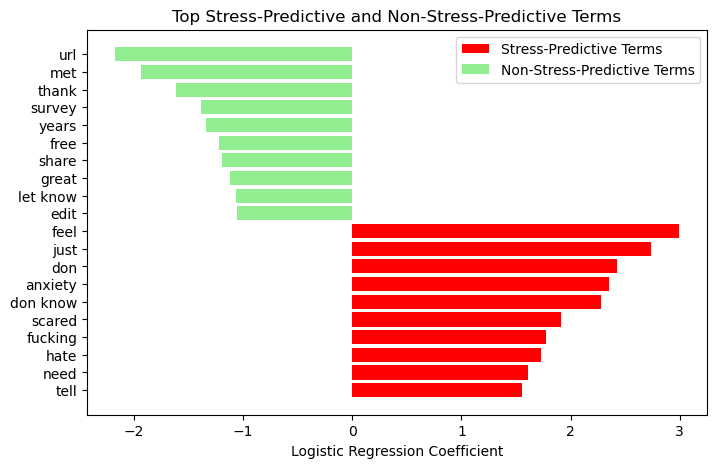

In [65]:
# plot both stress and non-stress terms in one plot, with different colors for stress and non-stress
def plot_top_terms(df, title, n=10):
    df_plot = df.head(n).iloc[::-1]
    plt.figure(figsize=(8,5))
    plt.barh(df_plot["stress_term"], df_plot["stress_coefficient"], color='red', label='Stress-Predictive Terms')
    plt.barh(df_plot["non_stress_term"], df_plot["non_stress_coefficient"], color='lightgreen', label='Non-Stress-Predictive Terms')
    plt.title(title)
    plt.xlabel("Logistic Regression Coefficient")
    plt.legend()

plot_top_terms(top_words_df, "Top Stress-Predictive and Non-Stress-Predictive Terms")

We observe that top stress-predictive and non-stress-predictive terms are very similar to previous TF-IDF analysis, with stress-predictive terms being more emotionally charged and non-stress-predictive terms being more informational and socially functional. This consistency reinforces the insights gained from the earlier analysis and highlights the robustness of the identified linguistic markers in distinguishing between stress-related and non-stress-related posts.

Some stress-predictive terms look like stop words (e.g., "just", "don"). We will attempt to remove them to see if performance is affected.

In [66]:
# rerun pipeline by adding a few stop words
additional_stop_words = ["just", "feel", "don", "ve"]

# combine with sklearn’s built-in English stopwords
custom_stop_words = list(ENGLISH_STOP_WORDS.union(additional_stop_words))
pipe2 = Pipeline([
    ("tfidf", TfidfVectorizer(stop_words=custom_stop_words)),
    ("clf", LogisticRegression(
        max_iter=2000,
        class_weight="balanced",
        solver="liblinear"
    ))
])

grid2 = GridSearchCV(
    pipe2,
    param_grid,
    scoring="f1",
    cv=cv,
    n_jobs=-1,
    return_train_score=True,
    verbose=1
)
grid2.fit(X, y)

# store results in dataframe
results_df2 = pd.DataFrame(grid.cv_results_)

# Keep only relevant columns
cols_to_keep = [
    "mean_test_score",
    "mean_train_score",
    "param_tfidf__max_features",
    "param_tfidf__ngram_range",
    "param_tfidf__min_df",
    "param_clf__C"
]

results_df2 = results_df2[cols_to_keep]

# Sort by best validation F1
results_df2 = results_df2.sort_values(
    by="mean_test_score",
    ascending=False
).reset_index(drop=True)
# rename test to val
results_df2 = results_df2.rename(columns={
    "mean_test_score": "mean_val_f1",
    "std_test_score": "std_val_f1",
    "mean_train_score": "mean_train_f1",
})

display(results_df2.head(5))

Fitting 5 folds for each of 96 candidates, totalling 480 fits


,mean_val_f1,mean_train_f1,param_tfidf__max_features,param_tfidf__ngram_range,param_tfidf__min_df,param_clf__C
0,0.750688,0.934040,10000,"(1, 2)",2,1.0
1,0.749569,0.932217,10000,"(1, 3)",2,1.0
2,0.745830,0.912547,5000,"(1, 3)",2,1.0
3,0.745056,0.909881,5000,"(1, 1)",2,1.0
4,0.744575,0.910435,10000,"(1, 1)",2,1.0


In [67]:
print("Best CV F1:", grid2.best_score_)
print("Best Parameters:")
print(grid2.best_params_)

Best CV F1: 0.7485823131284768
Best Parameters:
{'clf__C': 0.01, 'tfidf__max_features': 5000, 'tfidf__min_df': 2, 'tfidf__ngram_range': (1, 1)}


The best F1 score with stop words removed is 0.748, which is lower than the original score of 0.750. This suggests the these "stop words" may actually carry important contextual information that contributes to the model's ability to classify stress-related posts accurately. Removing them may have led to a loss of nuance in the language, which could explain the decrease in performance. Moving forward, we will keep these terms in the model as they appear to be relevant for the classification task.

### Per Sub-Reddit F1 Scores

Let us dive deeper into the performance of the model across different subreddits.

In [68]:
best_model = grid.best_estimator_

# Predict on test set
test_pred = best_model.predict(test["text"])

# Overall F1 (for reference)
overall_f1 = f1_score(test["label"], test_pred)
print("Overall Test F1:", overall_f1)

# also show support (how many samples per subreddit)
per_subreddit_with_n = (
    test.assign(pred=test_pred)
        .groupby("subreddit")
        .apply(lambda g: pd.Series({
            "f1": f1_score(g["label"], g["pred"]),
            "precision": precision_score(g["label"], g["pred"]),
            "recall": recall_score(g["label"], g["pred"]),
            "n": len(g), # number of samples in the subreddit
            "pos_rate": g["label"].mean(), # proportion of positive samples in the subreddit
        }), include_groups =False)
        .reset_index()
        .sort_values("f1", ascending=False)
)

display(per_subreddit_with_n)

Overall Test F1: 0.7239101717305152


,subreddit,f1,precision,recall,n,pos_rate
8,stress,0.823529,1.000000,0.700000,14.0,0.714286
6,ptsd,0.812500,0.833333,0.792683,127.0,0.645669
1,anxiety,0.806452,0.742574,0.882353,147.0,0.578231
4,food_pantry,0.800000,1.000000,0.666667,6.0,0.500000
3,domesticviolence,0.755556,0.790698,0.723404,72.0,0.652778
2,assistance,0.684211,0.764706,0.619048,66.0,0.318182
5,homeless,0.666667,0.583333,0.777778,52.0,0.346154
0,almosthomeless,0.608696,0.636364,0.583333,19.0,0.631579
7,relationships,0.582090,0.527027,0.650000,142.0,0.422535
9,survivorsofabuse,0.580645,0.580645,0.580645,70.0,0.442857


Calculating the F1-score for each subreddit reveals significant variability in model performance across different communities. Subreddits such as r/anxiety and r/ptsd show higher F1-scores. In contrast, subreddits like r/homeless and r/almosthomeless exhibit lower F1-scores. We will analyse this disparity by calculating the frequency of top stress and non-stress predictive terms in these subreddits.

### Macro Level Analysis

We will find out if the top predictive terms for stress and non-stress posts are more prevalent in subreddits with higher F1-scores. This analysis can provide insights into whether the model's performance is influenced by the presence of these key terms in the respective subreddits.

In [69]:
# extract top k stress and non-stress words by coefficient
k = 50
top_stress_coeff_words = set(top_words_df["stress_term"].head(k))
top_nonstress_coeff_words = set(top_words_df["non_stress_term"].head(k))
# extract top k stress and non-stress words by tf-idf delta
# initialize tfidf vectorizer with same parameters as best model
tfidf = TfidfVectorizer(
    stop_words='english',
    max_features=10000,
    min_df=2,
    ngram_range=(1,2)
)

# get the subreddit list in sorted order of f1 score
subreddit_order = per_subreddit_with_n.sort_values("f1", ascending=False)["subreddit"].tolist()
# dataframe to store proportions of overlap for each subreddit
overlap_df = pd.DataFrame(columns=["subreddit", "stress_overlap_prop", "nonstress_overlap_prop"])
for subreddit in subreddit_order:
    subset = test[test["subreddit"] == subreddit]
    X_subset = tfidf.fit_transform(subset["text"])
    feature_names = tfidf.get_feature_names_out()
    stress_mean = X_subset[subset['label'] == 1].mean(axis=0)
    nonstress_mean = X_subset[subset['label'] == 0].mean(axis=0)
    diff = np.asarray(stress_mean - nonstress_mean).flatten()
    top_stress_tfidf_words = set(
        [feature_names[i] for i in np.argsort(diff)[::-1][:k]]
    )
    top_nonstress_tfidf_words = set(
        [feature_names[i] for i in np.argsort(diff)[::-1][-k:]]
    )
    stress_overlap = top_stress_coeff_words.intersection(top_stress_tfidf_words)
    nonstress_overlap = top_nonstress_coeff_words.intersection(top_nonstress_tfidf_words)
    # calculate proportion of overlap
    stress_overlap_prop = len(stress_overlap) / k
    nonstress_overlap_prop = len(nonstress_overlap) / k
    print(f"Subreddit: {subreddit}")
    print(f"Stress Overlap: {stress_overlap}")
    print(f"Non-Stress Overlap: {nonstress_overlap}")
    print(f"Stress Overlap Proportion: {stress_overlap_prop:.2f}")
    print(f"Non-Stress Overlap Proportion: {nonstress_overlap_prop:.2f}")
    print()

Subreddit: stress
Stress Overlap: {'mentally', 'feel', 'don know', 'don', 'feel like', 'just', 'fucking', 'need', 'like', 'getting'}
Non-Stress Overlap: set()
Stress Overlap Proportion: 0.20
Non-Stress Overlap Proportion: 0.00

Subreddit: ptsd
Stress Overlap: {'hate', 'feel', 'stop', 'hard', 'know', 'feel like', 'just', 'scared', 'makes', 'don know', 'tired', 'like', 'tell', 'trying', 'anxiety', 'thinking', 'feeling', 'bad', 'days', 'past', 'happened'}
Non-Stress Overlap: {'great', 'url', 'thank', 'post', 'amazing', 'interested', 'link', 'years', 'share'}
Stress Overlap Proportion: 0.42
Non-Stress Overlap Proportion: 0.18

Subreddit: anxiety
Stress Overlap: {'worse', 'anxious', 'feel', 'don know', 'feeling', 'feel like', 'just', 'fucking', 'need', 'scared', 'right', 'like', 'hard', 'tell', 'terrified', 'anxiety'}
Non-Stress Overlap: {'people', 'decided', 'post', 'said', 'guys', 'good', 'met', 'years', 'share'}
Stress Overlap Proportion: 0.32
Non-Stress Overlap Proportion: 0.18

Subredd

Overlap analysis revealed that subreddit-specific stress-indicative terms exhibit only modest alignment with globally learned model coefficients. However, no clear relationship was observed between overlap proportion and F1 performance. This suggests that performance variation is not primarily driven by lexical mismatch, but likely reflects contextual ambiguity or discourse-level differences in stress expression.

### Micro Level Analysis

To better understand why the model makes certain predictions, we decomposed the logistic regression decision function into its component contributions. Specifically, for selected true positives (TP), true negatives (TN), false positives (FP), and false negatives (FN), we computed the decision score and separated it into: (1) the intercept term, (2) the cumulative contribution from top stress-indicative features, (3) the cumulative contribution from top non-stress-indicative features, and (4) the remaining contribution from all other features. This allows us to examine not just which words appear in a post, but how strongly they influence the model’s final decision.

In [70]:
def extract_examples_with_contrib_and_terms(subreddit, k=5, top_k_terms=50, top_terms_to_show=8):
    subset = test[test["subreddit"] == subreddit].copy()
    subset["pred"] = best_model.predict(subset["text"])

    tfidf = best_model.named_steps["tfidf"]
    clf = best_model.named_steps["clf"]
    feature_names = tfidf.get_feature_names_out()
    coef = clf.coef_.ravel()
    intercept = float(clf.intercept_.ravel()[0])

    top_stress_idx = np.argsort(coef)[::-1][:top_k_terms]
    top_non_idx    = np.argsort(coef)[:top_k_terms]

    def classify_row(row):
        if row["label"] == 1 and row["pred"] == 1: return "TP"
        if row["label"] == 0 and row["pred"] == 0: return "TN"
        if row["label"] == 0 and row["pred"] == 1: return "FP"
        return "FN"

    subset["type"] = subset.apply(classify_row, axis=1)
    subset["prediction_correct"] = subset["label"] == subset["pred"]

    selected = pd.concat([
        subset[subset["type"] == "TP"].head(k),
        subset[subset["type"] == "TN"].head(k),
        subset[subset["type"] == "FP"].head(k),
        subset[subset["type"] == "FN"].head(k),
    ]).copy()

    X = tfidf.transform(selected["text"].astype(str))

    # Full decision score
    selected["decision_score"] = clf.decision_function(X)
    selected["intercept"] = intercept

    # Top feature contributions
    stress_top = X[:, top_stress_idx].multiply(coef[top_stress_idx]).sum(axis=1)
    non_top    = X[:, top_non_idx].multiply(coef[top_non_idx]).sum(axis=1)

    selected["stress_top_contrib"] = np.asarray(stress_top).ravel()
    selected["nonstress_top_contrib"] = np.asarray(non_top).ravel()

    selected["rest_contrib"] = (
        selected["decision_score"]
        - selected["intercept"]
        - selected["stress_top_contrib"]
        - selected["nonstress_top_contrib"]
    )

    def dominant_part(r):
        parts = {
            "stress_top": abs(r["stress_top_contrib"]),
            "nonstress_top": abs(r["nonstress_top_contrib"]),
            "rest": abs(r["rest_contrib"]),
            "intercept": abs(r["intercept"]),
        }
        return max(parts, key=parts.get)

    selected["dominant_part"] = selected.apply(dominant_part, axis=1)

    # ---------- second DF: top contributing terms per row ----------
    def top_terms_for_row(row_idx, idxs, direction="stress"):
        """
        direction='stress' -> pick largest positive contributions among idxs
        direction='nonstress' -> pick most negative contributions among idxs
        """
        row = X[row_idx]
        # contribution vector for this subset of indices
        contrib = row[:, idxs].multiply(coef[idxs])  # sparse
        contrib = np.asarray(contrib.todense()).ravel()

        if direction == "stress":
            pick = np.argsort(contrib)[::-1]  # largest positive first
        else:
            pick = np.argsort(contrib)        # most negative first

        out = []
        for j in pick:
            if len(out) >= top_terms_to_show:
                break
            if contrib[j] == 0:
                continue
            term = feature_names[idxs[j]]
            out.append((term, float(contrib[j])))
        return out

    terms_rows = []
    selected = selected.reset_index(drop=False).rename(columns={"index": "orig_index"})
    for i in range(selected.shape[0]):
        stress_terms = top_terms_for_row(i, top_stress_idx, direction="stress")
        non_terms    = top_terms_for_row(i, top_non_idx, direction="nonstress")
        terms_rows.append({
            "orig_index": int(selected.loc[i, "orig_index"]),
            "type": selected.loc[i, "type"],
            "label": int(selected.loc[i, "label"]),
            "pred": int(selected.loc[i, "pred"]),
            "top_stress_terms": stress_terms,
            "top_nonstress_terms": non_terms,
        })

    terms_df = pd.DataFrame(terms_rows)

    # summary df (compact)
    summary_df = selected[[
        "orig_index", "text", "label", "pred", "type", "prediction_correct",
        "decision_score", "intercept",
        "stress_top_contrib", "nonstress_top_contrib", "rest_contrib",
        "dominant_part"
    ]]

    return summary_df, terms_df

In [71]:
summary_df, terms_df = extract_examples_with_contrib_and_terms("relationships", k=2)
display(summary_df)
# expand the display
pd.set_option("display.max_colwidth", None)   # show full text
pd.set_option("display.max_rows", None)       # show all rows
pd.set_option("display.max_columns", None)    # show all columns
pd.set_option("display.width", None)          # auto width
display(terms_df)
# reset display options to default
pd.reset_option("display.max_colwidth")
pd.reset_option("display.max_rows")
pd.reset_option("display.max_columns")
pd.reset_option("display.width")

,orig_index,text,label,pred,type,prediction_correct,decision_score,intercept,stress_top_contrib,nonstress_top_contrib,rest_contrib,dominant_part
0,32,I did a few times but it always just blew up i...,1,1,TP,True,1.868846,-0.581003,1.595246,0.000000,0.854603,stress_top
1,41,I've had other things happening - lack of dire...,1,1,TP,True,2.887432,-0.581003,3.156944,0.000000,0.311491,stress_top
2,0,"Its like that, if you want or not.“ ME: I have...",0,0,TN,True,-0.709165,-0.581003,0.107276,-0.305049,0.069610,intercept
3,15,"Despite being younger than him, I have had mor...",0,0,TN,True,-0.957274,-0.581003,0.279728,-0.400657,-0.255342,intercept
4,4,I haven’t said anything to him yet because I’m...,0,1,FP,False,0.411015,-0.581003,0.910302,-0.109633,0.191349,stress_top
5,36,His reason was that he would rather save money...,0,1,FP,False,0.017459,-0.581003,0.230841,0.000000,0.367621,intercept
6,33,I've been texting Rebecca on and off for the l...,1,0,FN,False,-0.525578,-0.581003,0.133297,-0.121758,0.043887,intercept
7,108,I wasn't sure when I argued with him and she s...,1,0,FN,False,-0.004974,-0.581003,0.809854,-0.441055,0.207229,stress_top


,orig_index,type,label,pred,top_stress_terms,top_nonstress_terms
0,32,TP,1,1,"[(just, 0.5637614691704833), (don know, 0.25748892842338567), (feel, 0.25587004139494984), (don, 0.1888946582994016), (feel like, 0.15501790132941548), (know, 0.0883623577323749), (like, 0.08585028085170149)]",[]
1,41,TP,1,1,"[(don know, 0.6420646997571859), (don, 0.6280274796505328), (feeling, 0.272529121147888), (boyfriend, 0.2565945362199391), (know, 0.22033704918755495), (feel, 0.2126759679999073), (past, 0.15086855184603096), (getting, 0.14272877072306248)]",[]
2,0,TN,0,0,"[(like, 0.1072760746418582)]","[(helped, -0.19071597451759126), (let, -0.11433257817522663)]"
3,15,TN,0,0,"[(past, 0.18813830188008288), (know, 0.09158930686831859)]","[(older, -0.1724181681975521), (person, -0.12798649968419504), (people, -0.10025238943074416)]"
4,4,FP,0,1,"[(need, 0.18758937632917874), (boyfriend, 0.16881422357973602), (dr, 0.15969718950947331), (tl dr, 0.14878058686378437), (tl, 0.14878058686378437), (know, 0.09664021801972368)]","[(said, -0.10963333921467218)]"
5,36,FP,0,1,"[(money, 0.2308408026104464)]",[]
6,33,FN,1,0,"[(ve, 0.13329662288855162)]","[(said, -0.12175825855051561)]"
7,108,FN,1,0,"[(feel, 0.35750926570226993), (sick, 0.13569536217816797), (just, 0.131284061090521), (tired, 0.12363450107652807), (know, 0.061731262981001254)]","[(said, -0.28012372625918447), (finally, -0.09354388966025413), (way, -0.06738772426852187)]"


In [72]:
summary_df, terms_df = extract_examples_with_contrib_and_terms("stress", k=2)
display(summary_df)
# expand the display
pd.set_option("display.max_colwidth", None)   # show full text
pd.set_option("display.max_rows", None)       # show all rows
pd.set_option("display.max_columns", None)    # show all columns
pd.set_option("display.width", None)          # auto width
display(terms_df)
# reset display options to default
pd.reset_option("display.max_colwidth")
pd.reset_option("display.max_rows")
pd.reset_option("display.max_columns")
pd.reset_option("display.width")

,orig_index,text,label,pred,type,prediction_correct,decision_score,intercept,stress_top_contrib,nonstress_top_contrib,rest_contrib,dominant_part
0,193,I am called back as a few secondary characters...,1,1,TP,True,0.201856,-0.581003,0.666386,-0.258768,0.375240,stress_top
1,319,I doubt and second guess myself a lot. I hesit...,1,1,TP,True,0.344686,-0.581003,0.310349,-0.116016,0.731355,rest
2,34,Should I stick around and save up my money? I ...,0,0,TN,True,-0.763398,-0.581003,0.304526,-0.340607,-0.146315,intercept
3,504,He had the sweetest voice and only the kindest...,0,0,TN,True,-0.245304,-0.581003,0.472425,-0.096965,-0.039761,intercept
4,465,It's really just standard-issue big corporatio...,1,0,FN,False,-0.037075,-0.581003,0.761885,-0.102478,-0.115479,stress_top
5,507,"We had 2 classes together, so we spent a few h...",1,0,FN,False,-0.205425,-0.581003,0.250358,0.000000,0.125220,intercept


,orig_index,type,label,pred,top_stress_terms,top_nonstress_terms
0,193,TP,1,1,"[(like, 0.1635503028875669), (sorry, 0.1280937522706784), (just, 0.11933353705290875), (need, 0.10891959346398586), (school, 0.0903765841410386), (know, 0.056111990268086345)]","[(bit, -0.1797837503373229), (guys, -0.07898395037755074)]"
1,319,TP,1,1,"[(afraid, 0.1848605734705113), (right, 0.12548879075320185)]","[(person, -0.11601611284792356)]"
2,34,TN,0,0,"[(right, 0.15692840328991206), (money, 0.14759760755437484)]","[(free, -0.219306292741004), (good, -0.1213006349828983)]"
3,504,TN,0,0,"[(past, 0.17217319337130552), (school, 0.13499986578348072), (know, 0.08381718812490385), (like, 0.08143432707530013)]","[(little, -0.09696548738785074)]"
4,465,FN,1,0,"[(just, 0.3982144426578026), (getting, 0.18193884048062917), (need, 0.18173162497708079)]","[(people, -0.10247787978942194)]"
5,507,FN,1,0,"[(days, 0.2503584696463434)]",[]


The resulting output includes several key columns. The decision_score represents the raw output of the logistic regression decision function before thresholding. A positive decision score corresponds to a stress prediction (class 1), while a negative decision score corresponds to a non-stress prediction (class 0). The intercept reflects the model’s baseline bias independent of any specific words in the text. The stress_top_contrib and nonstress_top_contrib columns represent the summed contributions (TF-IDF × coefficient) from the strongest positive and negative features respectively. The rest_contrib captures the combined effect of all remaining features not included in the top subsets. Together, these components sum to the final decision score.

Analysis of these contributions reveals that many true negative predictions are primarily driven by the negative intercept and cumulative non-stress feature contributions. Even when stress-related words are present, their weighted contribution is often insufficient to overcome the model’s baseline bias toward non-stress. This indicates that prediction errors are not necessarily due to the complete absence of stress vocabulary, but rather to insufficient aggregate evidence to cross the decision threshold. The model behaves conservatively, requiring strong cumulative stress signals before predicting the positive class.

Since the score is calculated as coeff * TF-IDF, the presence of stress-indicative words with high TF-IDF values can significantly increase the decision score, pushing it into the positive range for stress predictions. Conversely, if a post contains many non-stress-indicative words with high TF-IDF values, their negative contributions can outweigh the positive contributions from stress words, resulting in a negative decision score and a non-stress prediction. This dynamic illustrates how the model integrates multiple features to arrive at its final classification.

To put it simply, the model assumes posts are non-stress by default. It only predicts stress when there is enough weighted evidence. Some subreddits express stress in weaker or more narrative ways, so the accumulated signal does not exceed the threshold, leading to lower recall.

### Summary Analysis

Overall, subreddit-level performance differences are not primarily explained by vocabulary mismatch. Instead, the model’s conservative bias toward non-stress, reflected in its negative intercept and cumulative feature weighting mechanism, appears to play a more significant role. Errors arise when stress-related lexical signals are present but insufficient in magnitude to overcome the baseline decision threshold.

## LIWC + Sentiment (Non-Text)

This model uses LIWC features and sentiment scores as input to a logistic regression classifier. LIWC features capture various linguistic and psychological dimensions of the text, while sentiment scores provide an overall measure of the emotional tone. By combining these non-textual features, the model aims to predict stress labels based on the underlying psychological and emotional characteristics of the posts, rather than relying solely on specific word usage.

### Logistic Regression with LIWC and Sentiment Features

In [73]:
non_relevant_cols = [
    'post_id', 'sentence_range', 'text', 'id',
    'confidence', 'social_timestamp',
    'modified_label', 'label'
]
feature_cols = [c for c in train.columns if c not in non_relevant_cols]

X_train = train[feature_cols].copy()
y_train = train["label"].copy()
X_test  = test[feature_cols].copy()
y_test  = test["label"].copy()

In [74]:
# Identify categorical vs numeric columns
cat_cols = X_train.select_dtypes(include=["object", "category"]).columns.tolist()
num_cols = [c for c in X_train.columns if c not in cat_cols]

print("Categorical cols:", cat_cols)
print("Numeric cols:", num_cols[:10], "... total:", len(num_cols))

# ----------------------------
# Preprocess + model pipeline
# ----------------------------
preprocess = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), num_cols),
        ("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols),
    ],
    remainder="drop"
)

pipe = Pipeline([
    ("preprocess", preprocess),
    ("clf", LogisticRegression(max_iter=5000))
])

# ----------------------------
# Hyperparameter grid
# ----------------------------
param_grid = {
    "clf__C": [0.01, 0.1, 1, 10],
    "clf__penalty": ["l1", "l2"],
    "clf__solver": ["liblinear"],   # supports l1 and l2
    "clf__class_weight": [None, "balanced"],
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

grid = GridSearchCV(
    pipe,
    param_grid=param_grid,
    scoring="f1",
    cv=cv,
    n_jobs=-1,
    verbose=1,
    error_score="raise"
)

grid.fit(X_train, y_train)

print("Best params:", grid.best_params_)
print("Best CV F1:", grid.best_score_)

best_model_feat = grid.best_estimator_
test_pred = best_model_feat.predict(X_test)
print("Test F1:", f1_score(y_test, test_pred))

Categorical cols: ['subreddit']
Numeric cols: ['social_karma', 'syntax_ari', 'lex_liwc_WC', 'lex_liwc_Analytic', 'lex_liwc_Clout', 'lex_liwc_Authentic', 'lex_liwc_Tone', 'lex_liwc_WPS', 'lex_liwc_Sixltr', 'lex_liwc_Dic'] ... total: 109
Fitting 5 folds for each of 16 candidates, totalling 80 fits
Best params: {'clf__C': 10, 'clf__class_weight': None, 'clf__penalty': 'l2', 'clf__solver': 'liblinear'}
Best CV F1: 0.7810214244125772
Test F1: 0.7617801047120419


This model achieves a higher F1-score of 7.617 compared to the TF-IDF + Logistic Regression model, which had an F1-score of 0.723. This suggests that LIWC features and sentiment scores may provide more robust and generalizable indicators of stress-related content than TF-IDF features alone. The LIWC features capture deeper psychological and emotional dimensions of the text, while sentiment scores offer a holistic measure of emotional tone, allowing the model to better differentiate between stress and non-stress posts across various subreddits.

### Coefficient Analysis

In [75]:
best_model_feat = grid.best_estimator_
pre = best_model_feat.named_steps["preprocess"]
clf = best_model_feat.named_steps["clf"]

# feature names AFTER preprocessing (includes one-hot expanded cols)
feat_names = pre.get_feature_names_out()
coefs = clf.coef_.ravel()

coef_df = pd.DataFrame({
    "feature": feat_names,
    "coefficient": coefs,
    "abs_coef": np.abs(coefs)
}).sort_values("abs_coef", ascending=False).reset_index(drop=True)

coef_df["feature"] = (coef_df["feature"]
                      .str.replace("^num__", "", regex=True)
                      .str.replace("^cat__", "", regex=True))

display(coef_df.head(30))

,feature,coefficient,abs_coef
0,lex_liwc_function,1.125116,1.125116
1,lex_liwc_affect,1.098660,1.098660
2,lex_liwc_negemo,-1.068877,1.068877
3,lex_liwc_pronoun,-0.970299,0.970299
4,text_len,0.868830,0.868830
5,lex_liwc_WC,-0.686489,0.686489
6,subreddit_stress,0.685503,0.685503
7,lex_liwc_posemo,-0.648446,0.648446
8,lex_liwc_auxverb,-0.609072,0.609072
9,lex_liwc_Clout,-0.553777,0.553777


The engineered-feature model reveals that structural and stylistic features (function words, overall affect, and text length) contribute more strongly than raw positive or negative emotion counts.   
Interestingly, both positive and negative emotion LIWC categories showed negative coefficients when controlling for other features. We will run some tests to see possible explanations.  
Another interesting observation is that although r/anxiety contains the highest proportion of stress posts, its one-hot encoded feature did not emerge among the strongest coefficients. This suggests that much of the stress signal in r/anxiety is already captured by linguistic features such as affective and stylistic markers. In contrast, subreddits such as r/relationships contributed additional predictive information beyond linguistic content, indicating residual community-level effects.

In [76]:
train[["lex_liwc_affect", "lex_liwc_negemo", "lex_liwc_posemo"]].corr()

,lex_liwc_affect,lex_liwc_negemo,lex_liwc_posemo
lex_liwc_affect,1.000000,0.700567,0.541305
lex_liwc_negemo,0.700567,1.000000,-0.212387
lex_liwc_posemo,0.541305,-0.212387,1.000000


In [77]:
train.groupby("label")[["lex_liwc_negemo", "lex_liwc_affect", "lex_liwc_feel"]].mean()

,lex_liwc_negemo,lex_liwc_affect,lex_liwc_feel
label,,,
0,2.074133,5.579644,0.609556
1,4.421203,6.567137,1.186707


In [78]:
# 1. Single feature model
lr_single = LogisticRegression()
lr_single.fit(train[["lex_liwc_negemo"]], train["label"])
print("Single-feature coef:", lr_single.coef_)

# 2. Full model coef
print("Full model coef:")
print(coef_df[coef_df["feature"]=="lex_liwc_negemo"])

Single-feature coef: [[0.35557991]]
Full model coef:
           feature  coefficient  abs_coef
2  lex_liwc_negemo    -1.068877  1.068877


Although LIWC negative emotion words were substantially more prevalent in stress posts at the marginal level, their coefficient became negative in the multivariate logistic regression model. This indicates a suppression effect: once stronger correlates of stress such as overall affect, function word usage, and post length are accounted for, the residual variance in negative emotion words is associated with non-stress posts. Importantly, this pattern is unlikely to be driven by simple multicollinearity, as positive and negative emotion categories were not strongly correlated in the data. Instead, the reversal suggests that explicit negative emotional language shares overlapping variance with broader affective or stylistic markers, and that stress expression in this dataset is better characterized by cognitive-processing and structural linguistic patterns rather than isolated negative emotion words alone.

### Per Subreddit F1 Scores

In [79]:
# compute per subreddit f1 scores using best model
test["pred"] = best_model_feat.predict(X_test)
# overall f1 for reference
overall_f1 = f1_score(test["label"], test["pred"])
print("Overall Test F1:", overall_f1)

per_subreddit = (
    test.groupby("subreddit")
        .apply(lambda g: pd.Series({
            "f1": f1_score(g["label"], g["pred"]),
            "precision": precision_score(g["label"], g["pred"]),
            "recall": recall_score(g["label"], g["pred"]),
            "n": len(g),
            "pos_rate": g["label"].mean(),
        }), include_groups=False)
        .reset_index()
        .sort_values("f1", ascending=False)
)

display(per_subreddit)

Overall Test F1: 0.7617801047120419


,subreddit,f1,precision,recall,n,pos_rate
4,food_pantry,1.000000,1.000000,1.000000,6.0,0.500000
3,domesticviolence,0.860000,0.811321,0.914894,72.0,0.652778
8,stress,0.857143,0.818182,0.900000,14.0,0.714286
1,anxiety,0.816754,0.735849,0.917647,147.0,0.578231
0,almosthomeless,0.800000,0.769231,0.833333,19.0,0.631579
2,assistance,0.790698,0.772727,0.809524,66.0,0.318182
6,ptsd,0.775000,0.794872,0.756098,127.0,0.645669
9,survivorsofabuse,0.696970,0.657143,0.741935,70.0,0.442857
5,homeless,0.648649,0.631579,0.666667,52.0,0.346154
7,relationships,0.591304,0.618182,0.566667,142.0,0.422535


We see a similar pattern of variable performance across subreddits as the TF-IDF model. It seems that r/relationships, r/homeless and r/survivorsofabuse are again subreddits with the lower F1 scores.

### Macro Level Analysis

The engineered-feature model is driven primarily by stylistic and structural markers, including function word usage, affect, and post length, rather than isolated sentiment categories. Subreddit identity provides additional conditional signal, suggesting community-level differences beyond text content. Notably, LIWC negative emotion words showed a sign reversal despite being more prevalent in stress posts, indicating a suppression effect rather than simple multicollinearity. This suggests that stress expression in this dataset is characterized more by cognitive-processing patterns and linguistic structure than by explicit negative emotional vocabulary alone.

### Micro Level Analysis

For micro level analysis, we will plot feature SHAP values for different prediction types (TP, TN, FP, FN) to understand which features contribute most strongly to the model's decisions in each case. SHAP values provide a unified measure of feature importance by quantifying the contribution of each feature to the prediction for individual instances. By visualizing the distribution of SHAP values for the top features across different prediction types, we can gain insights into the specific linguistic and stylistic markers that drive correct and incorrect classifications of stress-related content in the dataset.

In [80]:
# -----------------------------
# 0) Setup: model + preprocess
# -----------------------------
model = grid.best_estimator_
pre = model.named_steps["preprocess"]
clf = model.named_steps["clf"]

# -----------------------------
# 1) Prepare test metadata
# -----------------------------
test_meta = test.copy().reset_index(drop=True)

# predictions (engineered-only model expects engineered cols)
test_meta["pred"] = model.predict(test_meta[feature_cols])

def get_type(row):
    if row["label"] == 1 and row["pred"] == 1: return "TP"
    if row["label"] == 0 and row["pred"] == 0: return "TN"
    if row["label"] == 0 and row["pred"] == 1: return "FP"
    return "FN"

test_meta["type"] = test_meta.apply(get_type, axis=1)

# optional: model confidence signals
Z_test = pre.transform(test_meta[feature_cols])
test_meta["decision_score"] = clf.decision_function(Z_test)
test_meta["pred_prob"] = expit(test_meta["decision_score"])

# -----------------------------
# 2) SHAP values for all test
# -----------------------------
# Using modern SHAP API with masker
masker = shap.maskers.Independent(Z_test)
explainer = shap.LinearExplainer(clf, masker)
shap_exp = explainer(Z_test)  # Explanation object

feature_names = pre.get_feature_names_out()
shap_values = shap_exp.values  # shape (n_samples, n_features)

# Make a SHAP DF for easy row-wise sorting
shap_df = pd.DataFrame(shap_values, columns=feature_names)

# -----------------------------
# 3) Aggregate top-k features per row, per subgroup
# -----------------------------
def collect_topk_records(
    test_meta,
    shap_df,
    top_k=5,
    min_group_n=5
):
    """
    For each subreddit x type:
      - For each row in that group:
          pick top_k positive SHAP (push stress)
          pick top_k negative SHAP (push non-stress)
      - Count feature frequency + mean SHAP when selected

    Returns a long dataframe with:
      subreddit, type, direction, feature, count, mean_shap, mean_abs_shap
    """
    records = []

    # iterate groups
    for (sr, t), idxs in test_meta.groupby(["subreddit", "type"]).groups.items():
        idxs = list(idxs)
        if len(idxs) < min_group_n:
            continue

        # For each row in this group
        for i in idxs:
            row = shap_df.iloc[i].values

            # top stress pushers (largest positive)
            pos_idx = np.argsort(row)[::-1]  # descending
            pos_picks = [j for j in pos_idx if row[j] > 0][:top_k]

            for j in pos_picks:
                records.append({
                    "subreddit": sr,
                    "type": t,
                    "direction": "push_stress",
                    "feature": shap_df.columns[j],
                    "shap": float(row[j]),
                    "abs_shap": float(abs(row[j]))
                })

            # top non-stress pushers (most negative)
            neg_idx = np.argsort(row)  # ascending
            neg_picks = [j for j in neg_idx if row[j] < 0][:top_k]

            for j in neg_picks:
                records.append({
                    "subreddit": sr,
                    "type": t,
                    "direction": "push_nonstress",
                    "feature": shap_df.columns[j],
                    "shap": float(row[j]),
                    "abs_shap": float(abs(row[j]))
                })

    long_df = pd.DataFrame(records)

    # aggregate: frequency and strength
    agg = (long_df
           .groupby(["subreddit", "type", "direction", "feature"])
           .agg(count=("feature", "size"),
                mean_shap=("shap", "mean"),
                mean_abs_shap=("abs_shap", "mean"))
           .reset_index()
           .sort_values(["subreddit", "type", "direction", "count"], ascending=[True, True, True, False])
          )

    return agg

agg_counts_df = collect_topk_records(test_meta, shap_df, top_k=5, min_group_n=5)

# display(agg_counts_df.head(30))

# -----------------------------
# 4) Convenience: top-N features per group
# -----------------------------
def top_features_per_group(agg_counts_df, subreddit, case_type, direction, top_n=10):
    return (agg_counts_df[
                (agg_counts_df["subreddit"] == subreddit) &
                (agg_counts_df["type"] == case_type) &
                (agg_counts_df["direction"] == direction)
            ]
            .sort_values(["count", "mean_abs_shap"], ascending=False)
            .head(top_n)
           )

# example:
# display(top_features_per_group(agg_counts_df, "relationships", "FP", "push_stress", top_n=10))

# -----------------------------
# 5) Build a pivot table for visualization
#    (example: global across all subreddits)
# -----------------------------
global_agg = (agg_counts_df
              .groupby(["type", "direction", "feature"])
              .agg(count=("count", "sum"),
                   mean_abs_shap=("mean_abs_shap", "mean"))
              .reset_index())

# Pivot: features x (type, direction) with counts
pivot_counts = global_agg.pivot_table(
    index="feature",
    columns=["type", "direction"],
    values="count",
    fill_value=0
)

# Pivot: features x (type, direction) with mean_abs_shap
pivot_strength = global_agg.pivot_table(
    index="feature",
    columns=["type", "direction"],
    values="mean_abs_shap",
    fill_value=0
)

# display(pivot_counts.head(20))
# display(pivot_strength.head(20))

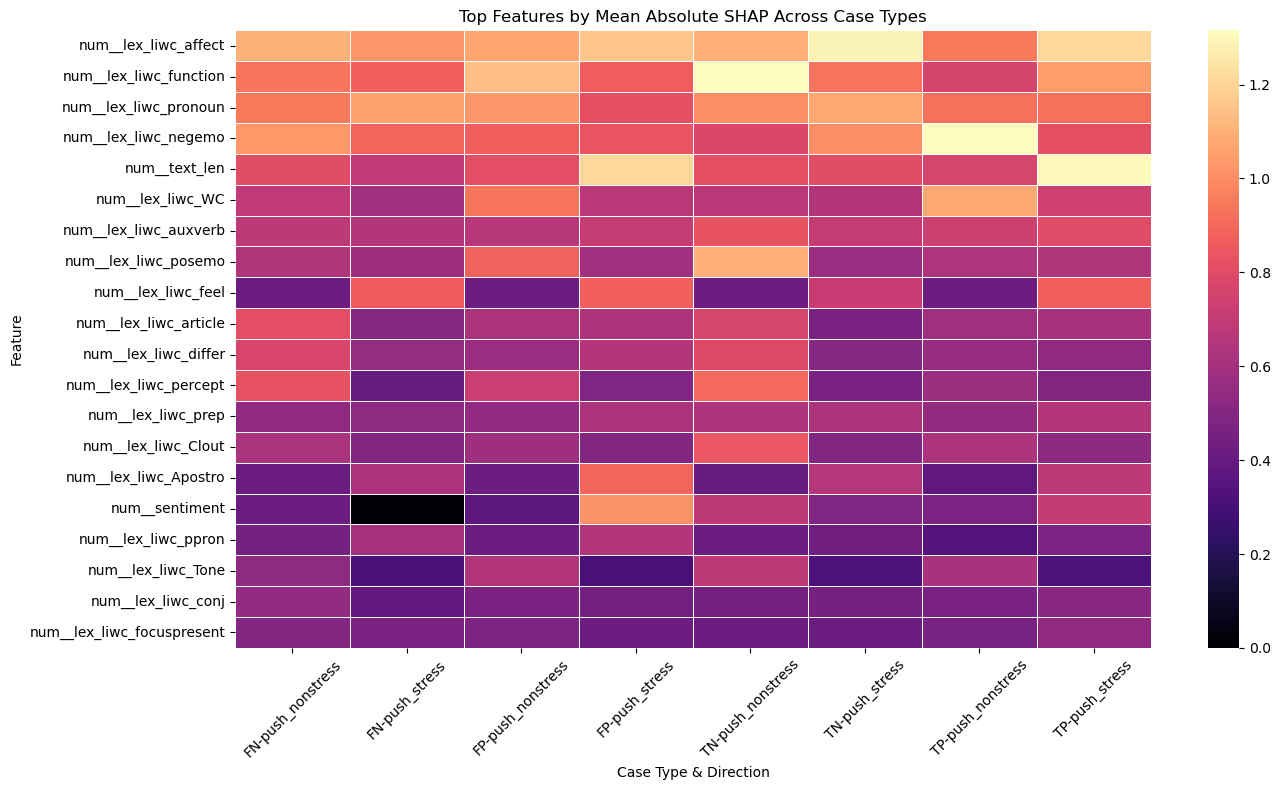

In [81]:
top_n = 20

feature_totals_strength = pivot_strength.sum(axis=1).sort_values(ascending=False)
top_features_strength = feature_totals_strength.head(top_n).index

heatmap_strength = pivot_strength.loc[top_features_strength]

plt.figure(figsize=(14, 8))
sns.heatmap(
    heatmap_strength,
    cmap="magma",
    linewidths=0.5
)
plt.title("Top Features by Mean Absolute SHAP Across Case Types")
plt.ylabel("Feature")
plt.xlabel("Case Type & Direction")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Based on this heat map, we can see that "text_len" pushes the model towards stress predictions across all case types, inlcuding both true positives and false positives. This suggests that longer posts are more likely to be classified as stress-related, which may reflect the tendency for individuals to provide more detailed narratives when expressing distress.  
To better visualise, we will plot bar charts for each prediction types.

In [82]:
def plot_top_features_return_set(
    agg_df,
    case_type="FP",
    direction="push_stress",
    top_n=10,
    sort_by="mean_abs_shap"
):
    subset = (
        agg_df[
            (agg_df["type"] == case_type) &
            (agg_df["direction"] == direction)
        ]
        .groupby("feature")
        .agg(
            count=("count", "sum"),
            mean_abs_shap=("mean_abs_shap", "mean")
        )
        .sort_values(sort_by, ascending=False)
        .head(top_n)
    )

    if case_type in ["FP", "FN"]:
         if direction == "push_stress":
          color = "darkred"
         else:
             color = "red"
    elif case_type in ["TP", "TN"]:
          if direction == "push_stress":
               color = "darkgreen"
          else:
               color = "lightgreen"

    plt.figure(figsize=(10,6))
    sns.barplot(
        x=subset["mean_abs_shap"],
        y=subset.index,
        orient="h",
        color= color
    )
    # x range should end at 3.5
    plt.title(f"Top {top_n} Features — {case_type} ({direction})")
    plt.xlabel("Mean Absolute SHAP Value")
    plt.xlim(0, 3.5)
    plt.ylabel("Feature")
    plt.tight_layout()
    plt.show()

    return set(subset.index)

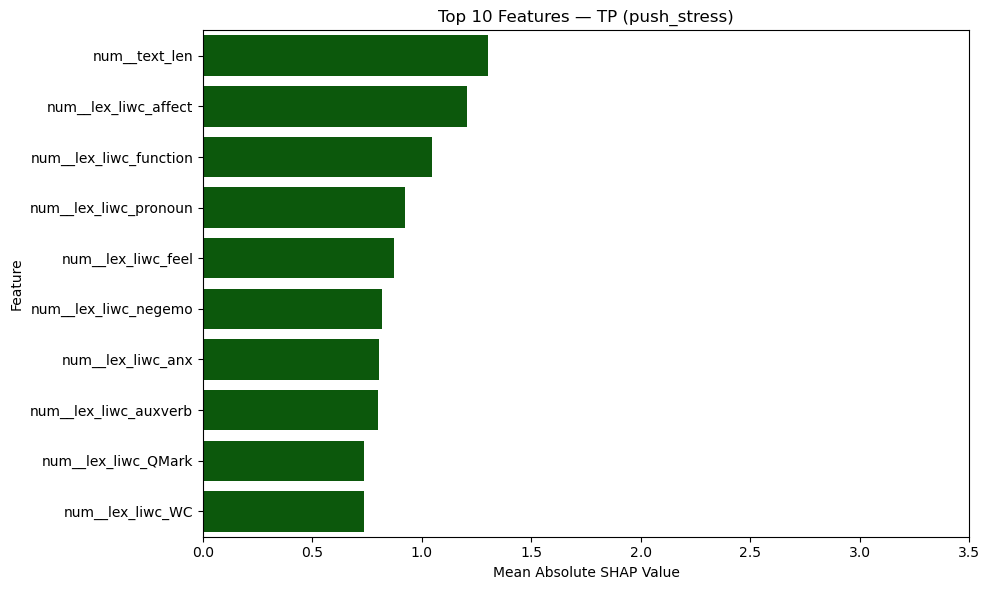

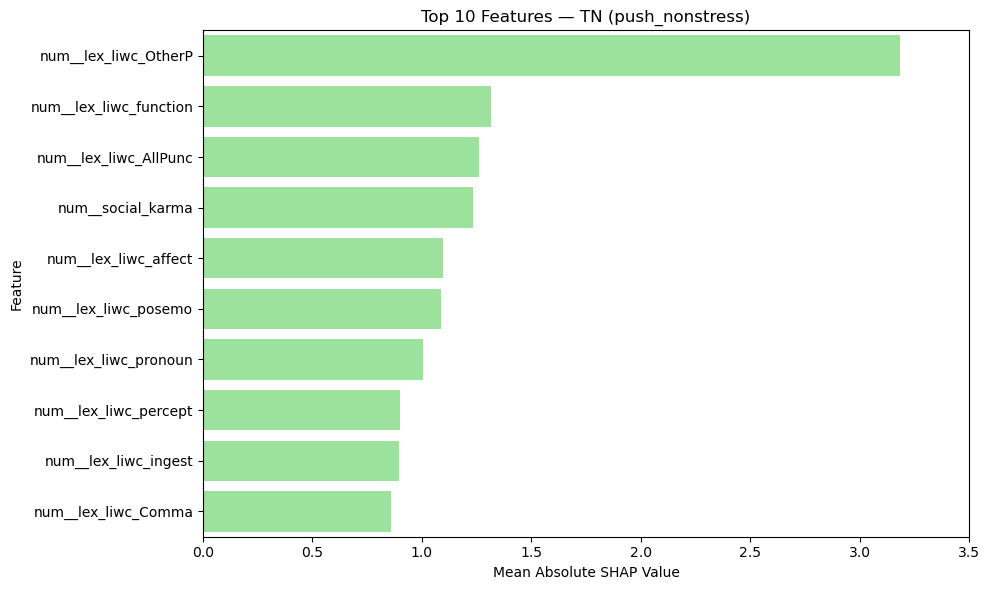

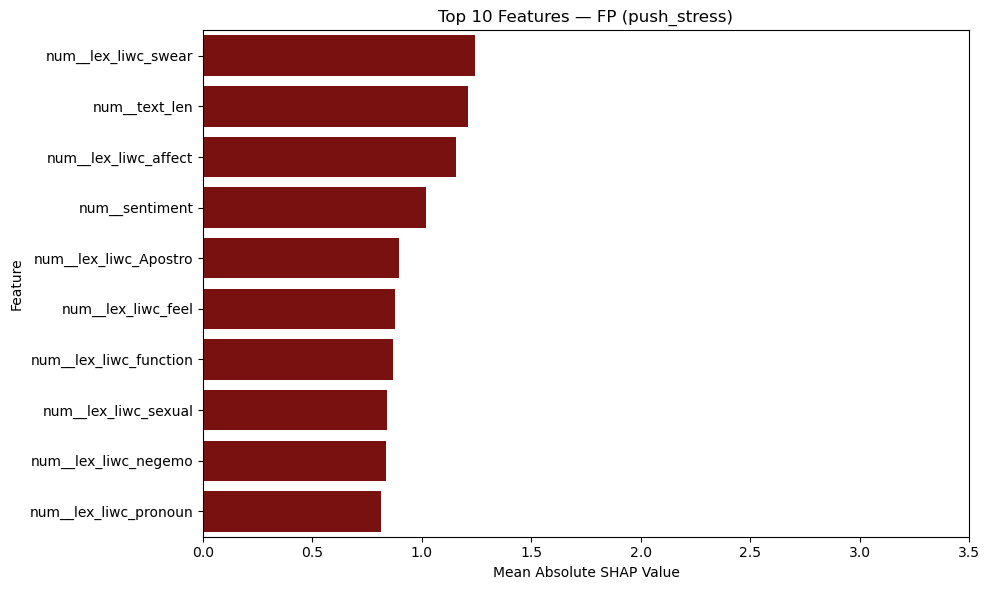

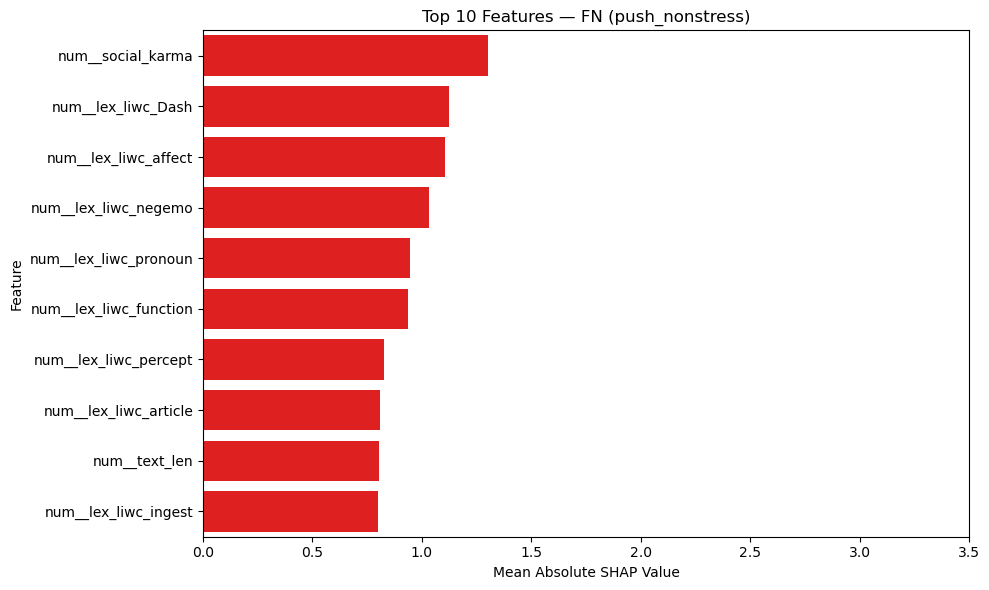

In [83]:
tp_set = plot_top_features_return_set(agg_counts_df, "TP", "push_stress", 10)
tn_set = plot_top_features_return_set(agg_counts_df, "TN", "push_nonstress", 10)
fp_set = plot_top_features_return_set(agg_counts_df, "FP", "push_stress", 10)
fn_set = plot_top_features_return_set(agg_counts_df, "FN", "push_nonstress", 10)

The bar chart reveals that text length (text_len) consistently functions as a dominant driver of stress predictions across all case types, including both true positives and false positives. This suggests that the model partially equates longer posts with stress expression. While this heuristic captures many genuine stress posts, it also increases false positives, indicating that verbosity alone is not a reliable stress indicator.

In contrast, social karma (social_karma) strongly drives non-stress predictions across both true negatives and false negatives, implying that users with higher engagement metrics are systematically classified as non-stress. This may reflect structural differences in posting behavior among highly engaged users. However, the presence of this feature in false negatives suggests that social status may inadvertently suppress legitimate stress signals.

The feature swear strongly pushes predictions toward stress in both true positives and false positives, indicating that the model treats profanity as a proxy for distress. While swear words often co-occur with emotional expression, their presence in casual or humorous contexts leads to systematic over-prediction of stress.

Interestingly, otherP (other-person pronouns) appears as a consistent driver of true negatives but does not strongly contribute to false negatives, suggesting it is a relatively reliable marker of non-stress discourse. This indicates that the model effectively leverages third-person references as a stabilizing feature rather than a source of systematic error.

Finally, affect appears across all prediction categories, pushing both stress and non-stress outcomes. This suggests it is a broad emotional intensity marker rather than a discriminative feature. Since high affect may signal distress, excitement, or gratitude depending on context, its bidirectional presence indicates limited discriminative power and contextual ambiguity.

In [84]:
def pretty_print_set(title, meaning, verdict, s):
    print(f"=== {title} ===")
    print(f"Meaning : {meaning}")
    print(f"Verdict : {verdict}")
    print(f"Count   : {len(s)}")
    print(f"Items   : {sorted(list(s))}\n")


# ---------------------------
# 1) "Good" blocks: unique to correct outcomes
# ---------------------------
unique_tp = tp_set - fp_set - fn_set - tn_set
pretty_print_set(
    title="Unique to TP (correct stress-only drivers)",
    meaning="Features that contribute only to True Positives (model correctly predicts stress).",
    verdict="GOOD: likely genuine stress signals (low confusion with wrong cases).",
    s=unique_tp
)

unique_tn = tn_set - fp_set - fn_set - tp_set
pretty_print_set(
    title="Unique to TN (correct non-stress-only drivers)",
    meaning="Features that contribute only to True Negatives (model correctly predicts non-stress).",
    verdict="GOOD: likely genuine non-stress signals (low confusion with wrong cases).",
    s=unique_tn
)


# ---------------------------
# 2) "Mixed / questionable" blocks: shared between correct & wrong of the same predicted class
# ---------------------------
fp_tp_shared = fp_set & tp_set
pretty_print_set(
    title="Shared FP & TP (stress-prediction drivers)",
    meaning="Features that push the model toward predicting stress in both True Positives and False Positives.",
    verdict=("MIXED: useful for detecting stress, but may cause false alarms. "
             "These features are stress-leaning but not specific."),
    s=fp_tp_shared
)

fn_tn_shared = fn_set & tn_set
pretty_print_set(
    title="Shared FN & TN (non-stress-prediction drivers)",
    meaning="Features that push the model toward predicting non-stress in both True Negatives and False Negatives.",
    verdict=("MIXED: useful for non-stress detection, but may miss true stress. "
             "These features are non-stress-leaning but may mask distress."),
    s=fn_tn_shared
)


# ---------------------------
# 3) "Bad" blocks: wrong-only or ubiquitous features
# ---------------------------
unique_fp = fp_set - tp_set - fn_set - tn_set
pretty_print_set(
    title="Unique to FP (wrong-only stress drivers)",
    meaning="Features that appear only in False Positives (model predicts stress when it shouldn't).",
    verdict=("BAD: likely spurious stress cues or context-dependent words (trigger false positives). "
             "Good candidates for error analysis."),
    s=unique_fp
)

unique_fn = fn_set - tp_set - fp_set - tn_set
pretty_print_set(
    title="Unique to FN (wrong-only non-stress drivers)",
    meaning="Features that appear only in False Negatives (model predicts non-stress when it is stress).",
    verdict=("BAD: likely misleading safety/neutral cues or missing stress markers (trigger false negatives). "
             "Important clinically because they cause missed distress."),
    s=unique_fn
)

common_all = fp_set & tp_set & fn_set & tn_set
pretty_print_set(
    title="Common to ALL (ubiquitous drivers)",
    meaning="Features appearing across TP, TN, FP, and FN (both correct and wrong cases).",
    verdict=("NOT VERY USEFUL: either very generic features or model-wide baseline signals. "
             "They don't help distinguish failure modes."),
    s=common_all
)

=== Unique to TP (correct stress-only drivers) ===
Meaning : Features that contribute only to True Positives (model correctly predicts stress).
Verdict : GOOD: likely genuine stress signals (low confusion with wrong cases).
Count   : 4
Items   : ['num__lex_liwc_QMark', 'num__lex_liwc_WC', 'num__lex_liwc_anx', 'num__lex_liwc_auxverb']

=== Unique to TN (correct non-stress-only drivers) ===
Meaning : Features that contribute only to True Negatives (model correctly predicts non-stress).
Verdict : GOOD: likely genuine non-stress signals (low confusion with wrong cases).
Count   : 4
Items   : ['num__lex_liwc_AllPunc', 'num__lex_liwc_Comma', 'num__lex_liwc_OtherP', 'num__lex_liwc_posemo']

=== Shared FP & TP (stress-prediction drivers) ===
Meaning : Features that push the model toward predicting stress in both True Positives and False Positives.
Verdict : MIXED: useful for detecting stress, but may cause false alarms. These features are stress-leaning but not specific.
Count   : 6
Items   : 

To better understand model behaviour, we categorised features above according to the confusion matrix outcomes in which they appear (True Positives, True Negatives, False Positives, and False Negatives). Features unique to True Positives (TP) or True Negatives (TN) are likely reliable signals, as they contribute exclusively to correct predictions of stress or non-stress, respectively. In contrast, features shared between TP and FP (or TN and FN) are mixed signals: while they push the model toward predicting stress (or non-stress), they lack specificity and may also contribute to misclassification. Finally, features unique to False Positives (FP) or False Negatives (FN) are particularly concerning, as they are associated only with incorrect predictions and may represent misleading lexical cues or context-dependent language. Features appearing across all four categories are likely generic or ubiquitous terms that provide little discriminative value. This decomposition allows us to distinguish between reliable stress indicators, ambiguous predictors, and potential sources of systematic error, thereby supporting deeper failure-mode analysis and interpretability.

## Hybrid Model (TF-IDF + LIWC)

This model combines both TF-IDF features and LIWC features as input to a logistic regression classifier. By integrating both textual and psychological dimensions of the posts, the hybrid model aims to leverage the strengths of both feature sets to improve stress classification performance. The TF-IDF features capture specific word usage patterns, while the LIWC features provide insights into the underlying emotional and cognitive processes reflected in the language. This comprehensive approach allows the model to better differentiate between stress-related and non-stress-related content across various subreddits.

In [85]:
TEXT_COL = "text"
TARGET_COL = "label"
SUBREDDIT_COL = "subreddit"

# Exclude non-features
exclude = {
    "post_id", "sentence_range", "id",
    "label", "modified_label", "confidence", "social_timestamp",
    TEXT_COL, SUBREDDIT_COL
}

# Numeric engineered features
engineered_cols = [
    c for c in train.columns
    if (c not in exclude) and (pd.api.types.is_numeric_dtype(train[c]))
]

print("Num engineered cols:", len(engineered_cols))

Num engineered cols: 109


In [86]:
X_train = train[[TEXT_COL, SUBREDDIT_COL] + engineered_cols]
y_train = train[TARGET_COL]

X_test = test[[TEXT_COL, SUBREDDIT_COL] + engineered_cols]
y_test = test[TARGET_COL]

preprocess = ColumnTransformer(
    transformers=[
        # Text → TF-IDF
        ("tfidf", TfidfVectorizer(
            stop_words="english",
            max_features=10000,
            ngram_range=(1,2),
            min_df=5
        ), TEXT_COL),

        # Numeric engineered → scaled
        ("num", StandardScaler(with_mean=False), engineered_cols),

        # Subreddit → one-hot encode
        ("sub", OneHotEncoder(handle_unknown="ignore"), [SUBREDDIT_COL]),
    ],
    remainder="drop"
)

hybrid_model = Pipeline([
    ("prep", preprocess),
    ("clf", LogisticRegression(
        max_iter=2000,
        class_weight="balanced",
        solver="liblinear"
    ))
])

In [87]:
param_grid = {
    "prep__tfidf__max_features": [5000, 10000],
    "prep__tfidf__ngram_range": [(1,1), (1,2)],
    "prep__tfidf__min_df": [2, 5],
    "clf__C": [0.1, 1.0, 10.0],
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

hybrid_grid = GridSearchCV(
    hybrid_model,
    param_grid,
    scoring="f1",
    cv=cv,
    n_jobs=-1,
    verbose=1,
    return_train_score=True
)

hybrid_grid.fit(X_train, y_train)

print("Best CV F1:", hybrid_grid.best_score_)
print("Best params:", hybrid_grid.best_params_)

Fitting 5 folds for each of 24 candidates, totalling 120 fits
Best CV F1: 0.7805952928730072
Best params: {'clf__C': 1.0, 'prep__tfidf__max_features': 5000, 'prep__tfidf__min_df': 5, 'prep__tfidf__ngram_range': (1, 1)}


In [88]:
hybrid_results = pd.DataFrame(hybrid_grid.cv_results_).sort_values("mean_test_score", ascending=False)
display(hybrid_results[[
    "mean_test_score", "std_test_score",
    "mean_train_score", "std_train_score",
    "param_prep__tfidf__max_features",
    "param_prep__tfidf__ngram_range",
    "param_prep__tfidf__min_df",
    "param_clf__C"
]].head(10))

,mean_test_score,std_test_score,mean_train_score,std_train_score,param_prep__tfidf__max_features,param_prep__tfidf__ngram_range,param_prep__tfidf__min_df,param_clf__C
14,0.780595,0.017557,0.865512,0.003245,10000,"(1, 1)",5,1.0
10,0.780595,0.017557,0.865512,0.003245,5000,"(1, 1)",5,1.0
11,0.779639,0.018368,0.867729,0.003341,5000,"(1, 2)",5,1.0
15,0.779639,0.018368,0.867729,0.003341,10000,"(1, 2)",5,1.0
9,0.779154,0.018280,0.870330,0.003543,5000,"(1, 2)",2,1.0
8,0.778782,0.019526,0.869771,0.003979,5000,"(1, 1)",2,1.0
12,0.778782,0.019526,0.869896,0.003911,10000,"(1, 1)",2,1.0
21,0.778340,0.011166,0.997481,0.000593,10000,"(1, 2)",2,10.0
13,0.778330,0.018750,0.873218,0.002388,10000,"(1, 2)",2,1.0
0,0.774494,0.019259,0.809365,0.004743,5000,"(1, 1)",2,0.1


In [89]:
best_hybrid = hybrid_grid.best_estimator_
test_pred = best_hybrid.predict(X_test)

print("Hybrid Test F1:", f1_score(y_test, test_pred))

Hybrid Test F1: 0.7626666666666667


The hybrid model achieves an F1-score of 0.762, which is a miniscule improvement over the LIWC-only model (F1-score of 0.7617) and a more substantial improvement over the TF-IDF-only model (F1-score of 0.723). This suggests that while the integration of TF-IDF features provides some additional predictive power, the LIWC features are already capturing much of the relevant information for stress classification. The modest gain from the hybrid approach indicates that the psychological and emotional dimensions captured by LIWC may be more critical for distinguishing stress-related content than specific word usage patterns alone.

# Summary and Conclusion

In this assignment we used three models to classify stress-related posts: a text-only TF-IDF + Logistic Regression model, an engineered-feature model using LIWC and sentiment features, and a hybrid model combining both. The LIWC-based model outperformed the TF-IDF model, suggesting that psychological and emotional features are more informative for stress classification than raw word usage. The hybrid model provided only a marginal improvement over the LIWC model, indicating that the added lexical features did not substantially enhance predictive power. Subreddit-level analysis revealed variable performance, with certain communities exhibiting lower F1-scores likely due to contextual differences in stress expression. Micro-level analysis of feature contributions highlighted the dominant role of post length and social engagement metrics in driving predictions, while also revealing potential sources of systematic error such as profanity. Overall, the findings suggest that stress expression in this dataset is better captured by cognitive-processing and stylistic markers rather than isolated lexical features, and that community-level factors may influence model performance.

# Clinical Ethics

1. Clinical Risk: False Negatives vs False Positives

Although the model achieves reasonable performance metrics, the ethical implications of its errors differ substantially. In the context of stress detection, false negatives (FN) represent a significant clinical concern. A false negative occurs when a genuinely stressed post is classified as non-stress, potentially preventing timely identification of individuals who may benefit from support. If deployed in a triage or intervention system, such misclassification could delay outreach, crisis resources, or moderation escalation. In high-risk settings, prioritising recall (minimising false negatives) may therefore be more ethically appropriate than optimising overall F1-score.

By contrast, false positives (FP), where non-stress posts are flagged as stress, carry different risks. While less clinically dangerous, they may result in unnecessary intervention, misallocation of limited mental health resources, or user frustration. Over-flagging could also reduce trust in the system, especially if users perceive the model as inaccurately labelling casual or humorous language (e.g., swear words) as distress. Thus, model deployment must carefully balance sensitivity and specificity depending on the intended use case (e.g., research monitoring vs crisis triage).

2. Risk of Linguistic Bias and Misinterpretation

The model’s reliance on features such as text length, swear word frequency, and affect-related LIWC categories introduces additional ethical considerations. For example, if swear words strongly push predictions toward stress, individuals using expressive or informal language styles may be disproportionately flagged. Similarly, longer posts being more likely classified as stress-related could reflect verbosity rather than genuine distress.

Such patterns suggest that the model may partially capture stylistic signals rather than true psychological state. This creates a risk of systematic bias, where certain communication styles or subreddit cultures are over- or under-identified as stress-related. Ethical deployment therefore requires ongoing auditing to ensure that predictions reflect meaningful distress signals rather than superficial linguistic markers.

3. Automated Surveillance and Privacy Concerns

Beyond predictive performance, deploying automated stress detection systems raises broader concerns about surveillance and autonomy. Continuous monitoring of user-generated content to infer psychological state may constitute a form of emotional profiling. If implemented without explicit consent, such systems risk undermining user privacy and trust.

Even when deployed with benevolent intentions, there remains potential for misuse, such as institutional monitoring of individuals or algorithmic labelling without transparency. To mitigate these risks, any real-world application should incorporate:

- Clear user consent mechanisms
- Transparency about how predictions are generated
- Explainability of model outputs
- Strict data governance and anonymisation
- Human-in-the-loop review before intervention

Importantly, such systems should assist rather than replace professional judgment, and predictions should not be interpreted as clinical diagnoses.

4. Appropriate Deployment Framing

Given these risks, the model is best positioned as a screening or research tool, rather than an autonomous decision-making system. Its outputs may help identify population-level trends or prioritise review queues, but final intervention decisions should remain under human oversight. Additionally, threshold tuning should reflect the ethical objective: if early detection of distress is prioritised, the system may tolerate more false positives to minimise false negatives.

# Declaration of AI Use

AI was used in this assignment for the following purposes:
- Generating code to compute TF-IDF features and train logistic regression models
- Refining analysis and explanations

